# Fundamental Diagrams regarding Measurement Lines

This guide will show how it is possible to calculate speed, flow and density when analysing pedestrian trajectories at a measurement line.

The Voronoi decomposition can be used to determine fields in which velocity, flow and density can be measured at a specific point. With these calculations it is also possible to compute measurement values at a measurement line.

The proportion of the Voronoi cell on the line determines the proportion of the pedestrian's measured values in the result.

$$ v_{l0} = \sum_i v_{i,n_{l0}} * w_{i,l0}  $$
This is an example of a simplified speed calculation. It can be seen that the speed at the measurement line ($v_{l0}$) is calculated from the speed of pedestrian $i$ orthogonal to the measurement line ($v_{i,n_{l0}}$) and his proportion of the line ($w_{i,l0}$).
  The density and flow can be calculated in a similar way. How exactly the measured values are determined is explained in the following guide.

## Setup Files

First, the trajectories must be loaded. In this guide, the data from four experiments are analyzed. Two of the experiments have a unidirectional main movement direction. The other two have a bidirectional main movement direction. The main movement direction is aligned so that it is orthogonal to the measurement line. This will later also be illustrated in a plot. 

The file dictionary consists of a key name, which is later used for the trajectory, the path to the data and an additional unit if this is not specified in the trajectory data.

In [1]:
from pedpy import TrajectoryUnit

files = {
    "unidirectional 1": (
        "demo-data/uni-directional/traj_UNI_CORR_500_08.txt",
        TrajectoryUnit.METER,
    ),
    "unidirectional 2": (
        "demo-data/uni-directional/traj_UNI_CORR_500_03.txt",
        TrajectoryUnit.METER,
    ),
    "bidirectional 1": ("demo-data/bi-directional/bi_corr_400_b_08.txt", None),
    "bidirectional 2": ("demo-data/bi-directional/bi_corr_400_b_03.txt", None),
}

## load trajectories

In [2]:
from pedpy import load_trajectory
import pathlib

trajectories = {}
for name, (path, unit) in files.items():
    trajectories[name] = load_trajectory(
        trajectory_file=pathlib.Path(path), default_unit=unit
    )

## Define Geometries and Measurement lines

In order to determine the Voronoi polygons and plot the trajectories in a later step, the {class}`walkable area <geometry.WalkableArea>` of the experiment must first be defined.

In [3]:
from pedpy import WalkableArea

walkable_areas = {
    "unidirectional 1": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (6.5, -1.5), (6.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-6.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-6.0, -1.0)],
            # upper Wall:
            [(-6.0, 5.0), (5.0, 5.0), (5.0, 6.0), (-6.0, 6.0)],
        ],
    ),
    "unidirectional 2": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (6.5, -1.5), (6.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-6.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-6.0, -1.0)],
            # upper Wall:
            [(-6.0, 5.0), (5.0, 5.0), (5.0, 6.0), (-6.0, 6.0)],
        ],
    ),
    "bidirectional 1": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (5.5, -1.5), (5.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-6.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-6.0, -1.0)],
            # upper Wall:
            [(-6.0, 4.0), (5.0, 4.0), (5.0, 5.0), (-6.0, 5.0)],
        ],
    ),
    "bidirectional 2": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (5.5, -1.5), (5.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-5.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-5.0, -1.0)],
            # upper Wall:
            [(-5.0, 4.1), (5.0, 4.1), (5.0, 5.0), (-5.0, 5.0)],
        ],
    ),
}

The {class}`measurement line <geometry.MeasurementLine>` defines where the characteristics of the test data are to be measured. To obtain correct results, it is important that the measurement line is orthogonal to the main direction of movement. There should be no pedestrians walking parallel to the line.

In [4]:
from pedpy import MeasurementLine

measurement_lines = {
    "unidirectional 1": MeasurementLine([(0.0, 0.0), (0.0, 5.0)]),
    "unidirectional 2": MeasurementLine([(0.0, 0.0), (0.0, 5.0)]),
    "bidirectional 1": MeasurementLine([(0.0, 0.0), (0.0, 4.0)]),
    "bidirectional 2": MeasurementLine([(0.0, 0.0), (0.0, 4.0)]),
}

the plotted trajectories, geometry, and measurement lines look like this:

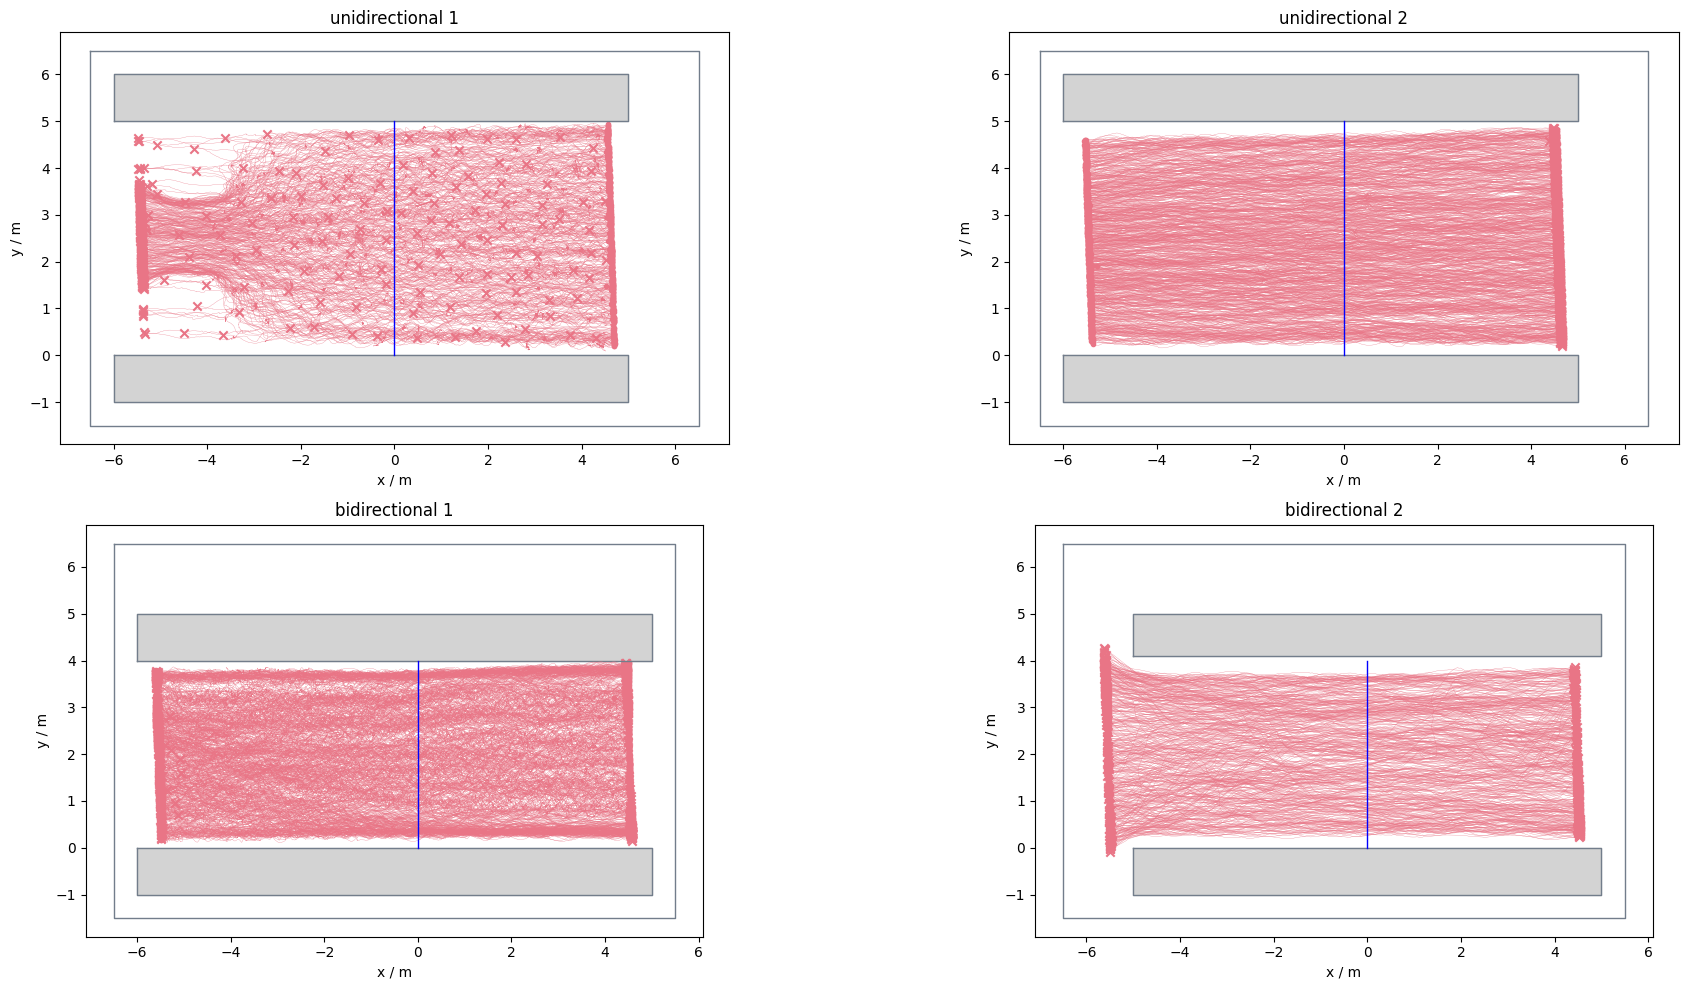

In [5]:
import matplotlib.pyplot as plt
from pedpy import plot_measurement_setup

fig, axs = plt.subplots(2, int(len(trajectories) / 2), figsize=(20, 10))

for (name, trajectory), ax in zip(trajectories.items(), axs.ravel()):
    ax.set_title(name)

    ax = plot_measurement_setup(
        traj=trajectory,
        walkable_area=walkable_areas[name],
        measurement_lines=[measurement_lines[name]],
        axes=ax,
        traj_width=0.2,
        traj_start_marker=".",
        traj_end_marker="x",
        ma_color="g",
        ma_line_color="g",
        ma_alpha=0.2,
        ml_color="b",
    )
    ax.set_aspect("equal")

fig.tight_layout()
plt.show()

In the plot above shows the setup of the experimental data analysed in this Notebook. It consists of unidirectional and bidirectional experiments. One line represents the trajectory of one agent. Starting positions are marked with a dot and end positions are marked with an x. The blue line shows the measurement line.

## Calculate Voronoi Polygons

The Voronoi decomposition will be used to create a scalar field to measuring speed and density. It is highly recommended to use a cutoff when calculating the Voronoi polygons, as the resulting data can be inaccurate if individual pedestrians at the edge of a group have an impact on large areas, even if they are very far away.

Note that the calculation of the Voronoi polygons will take a while.

In [6]:
from pedpy.methods.method_utils import (
    compute_individual_voronoi_polygons,
    Cutoff,
)

individual_cutoffs = {}

In [7]:
individual_cutoffs["unidirectional 1"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["unidirectional 1"],
    walkable_area=walkable_areas["unidirectional 1"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

In [8]:
individual_cutoffs["unidirectional 2"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["unidirectional 2"],
    walkable_area=walkable_areas["unidirectional 2"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

In [9]:
individual_cutoffs["bidirectional 1"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["bidirectional 1"],
    walkable_area=walkable_areas["bidirectional 1"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

In [10]:
individual_cutoffs["bidirectional 2"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["bidirectional 2"],
    walkable_area=walkable_areas["bidirectional 2"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

## determine the individual speed

When calculating the individual velocity, make sure that the "compute velocity" option is used. The choice of the frame step is also important. The frame step determines how many frames before and after the current position are used for the calculation of the movement. If too many frames are selected, smaller movements against the main direction of movement may no longer be included in the overall image. The value for the individual speed of some frames could then be positive, even if it should actually be negative.

When calculating the individual speed it might be necessary to specify the speed calculation for border cases. The default Speed calculation is BORDER_EXCLUDE this excludes values at the edges of the trajectory data. If some values necessary for a later calculation are missing you will run into an error.      

It is possible to cut a few frames from the trajectory data used to determine the Voronoi polygons. If there are more frames at the beginning and end of the data used for the individual speed calculation than in the Voronoi decomposition, it is possible to solve the Problem while keeping the same speed calculation.

You could also consider using a different speed calculation. The different calculation methods and further details how the individual speed is calculated are explained in the [user guide](user_guide).


In [11]:
from pedpy.methods.speed_calculator import (
    compute_individual_speed,
    SpeedCalculation,
)

calculation_methods = {
    "unidirectional 1": SpeedCalculation.BORDER_SINGLE_SIDED,
    "unidirectional 2": SpeedCalculation.BORDER_EXCLUDE,
    "bidirectional 1": SpeedCalculation.BORDER_EXCLUDE,
    "bidirectional 2": SpeedCalculation.BORDER_EXCLUDE,
}

individual_speeds = {}

for name in trajectories:
    individual_speeds[name] = compute_individual_speed(
        traj_data=trajectories[name],
        frame_step=1,
        compute_velocity=True,
        speed_calculation=calculation_methods[name],
    )

## determine the Species for each pedestrian

the species of the pedestrian decides from which side they encounter the measurement line. Accordingly, there are two possible main directions of movement orthogonal to the line. Here they are later referred to as Species 1 and 2. 

The decision which species represents a pedestrian is made by analyzing the first frame in which its Voronoi cell touches the line. The sign of the orthogonal velocity to the line $n * v(t_{i,l0})$ is defined as the movement factor $m$ of a pedestrian. The movement factor shows which main direction the pedestrian follows.

$$ m = n * v(t_{i,l0}) $$

$n$ is the normal vector of the measurement line and $v(t_{i,l0})$ is the velocity of pedestrian $i$ when he touches the line $l0$

```{eval-rst}
.. figure:: images/species_determination.svg
    :align: center
```
This image shows the frame when the decision as to which species the pedestrian belongs to is made. It is the first frame in which his Voronoi cell intersects the line. Now the current velocity decides which species they are assigned to.

In the decision it is not relevant whether a pedestrian actually crosses the line afterward. Even if he only walks to the line and then turns back without crossing the measuring line, his species is determined correctly. If a pedestrian moves against their main direction of movement after initially being next to the line, their species will not change and the speed of their movement perpendicular to the line will be correctly calculated as negative.

In [12]:
from pedpy.methods.speed_calculator import compute_species

species = {}

for name in trajectories:
    species[name] = compute_species(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        trajectory_data=trajectories[name],
        frame_step=25,
    )

## Compute speed at line

To determine the total speed perpendicular to the measuring line in a specific frame, all pedestrians whose Voronoi polygon is a part of the measuring line are taken into account.

```{eval-rst}
.. figure:: images/voronoi_at_line.svg
    :align: center
```

The speed of a single pedestrian results from the individual orthogonal speed multiplied by the share of the line. 

$$ v_{i}(t) * n_{l0} *  \frac{w_i(t)}{w}$$ 

Here $w_i(t)$ is the length of the part of the measurement line cut by the Voronoi cell and $w$ is the total length of the measurement line.

For pedestrians of species 2 negative individual velocities occur, because the main direction of movement of these pedestrians runs opposite to the normal vector of the measuring line. To correct the sign, the individual speeds are multiplied by the movement factor $m$ in the calculation. the movement factor was calculated when determining the species.
The speed $u$ of a species $S$ can be calculated by the sum of all pedestrians of the species. 

$$ u^S = \sum_{i} m * v_i(t) * n_{l0} *  \frac{w_i(t)}{w}  \text{ with } i \epsilon S $$

the total density combines the values of both species

$$ v = v^{\mathrm{I}} + v^{\mathrm{II}}$$ 

In [13]:
from pedpy.methods.speed_calculator import compute_line_speed

speeds = {}
for name in trajectories:
    speeds[name] = compute_line_speed(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        individual_speed=individual_speeds[name],
        species=species[name],
    )

Now the speed on the line over time can be plotted.

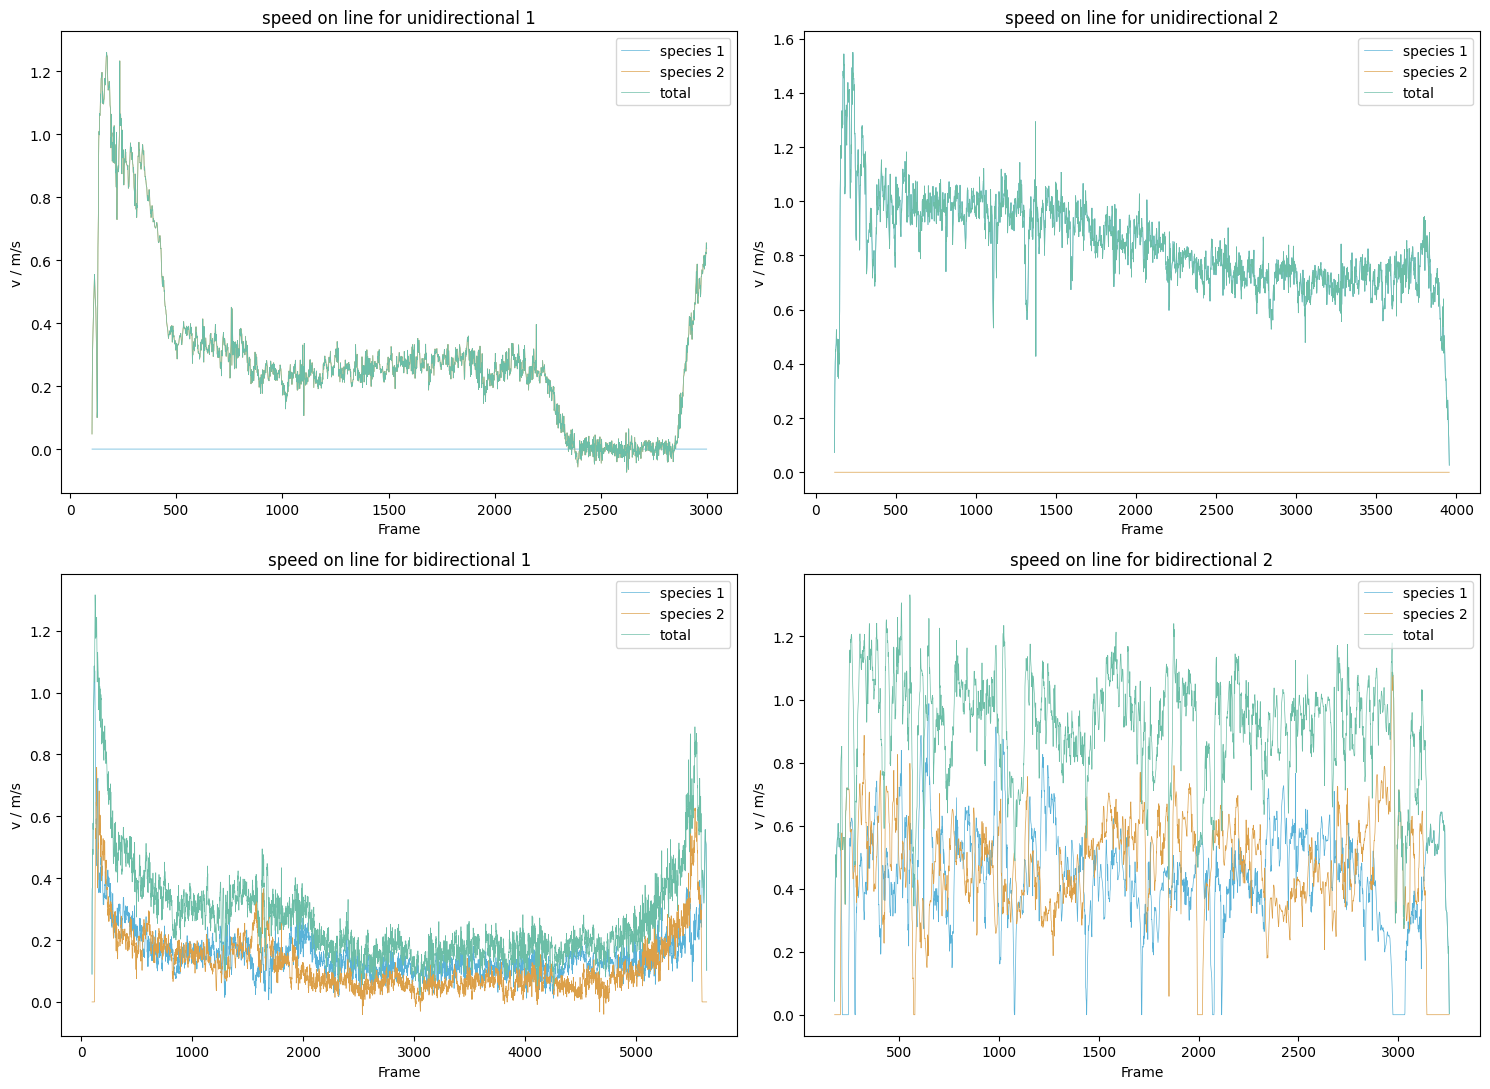

In [14]:
from pedpy.plotting.plotting import plot_speed_at_line
import matplotlib.pylab as plt

fig, axs = plt.subplots(2, int(len(speeds) / 2), figsize=(15, 11))

for (name, speed_on_line), ax in zip(speeds.items(), axs.ravel()):
    ax = plot_speed_at_line(
        speed_at_line=speed_on_line,
        axes=ax,
        line_width=0.5,
        title="speed on line for " + name,
    )

fig.tight_layout()
plt.show()

## Compute Density on the Line

The density on the line is computed from the densities of a pedestrian Voronoi Cell proportional to their share on the Line.
The Density of a Species only considers the pedestrians representing the species.

$$ p^S = \sum_{i} \frac{1}{A_i(t)} *  \frac{w_i(t)}{w}  \text{ with } i \epsilon S $$
$A_i(t)$ is the amount of space the Voronoi Cell of pedestrian $i$ takes up.
$\frac{w_i(t)}{w}$ is again the fraction of the line that is intersected by the Voronoi cell of pedestrian i.

the total density combines the values of Species 1 and 2.

$$ p = p^{\mathrm{I}} + p^{\mathrm{II}}$$ 

In [15]:
from pedpy.methods.density_calculator import compute_line_density

densities = {}
for name in trajectories:
    densities[name] = compute_line_density(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        species=species[name],
    )

Now the density on the line over time can be plotted.

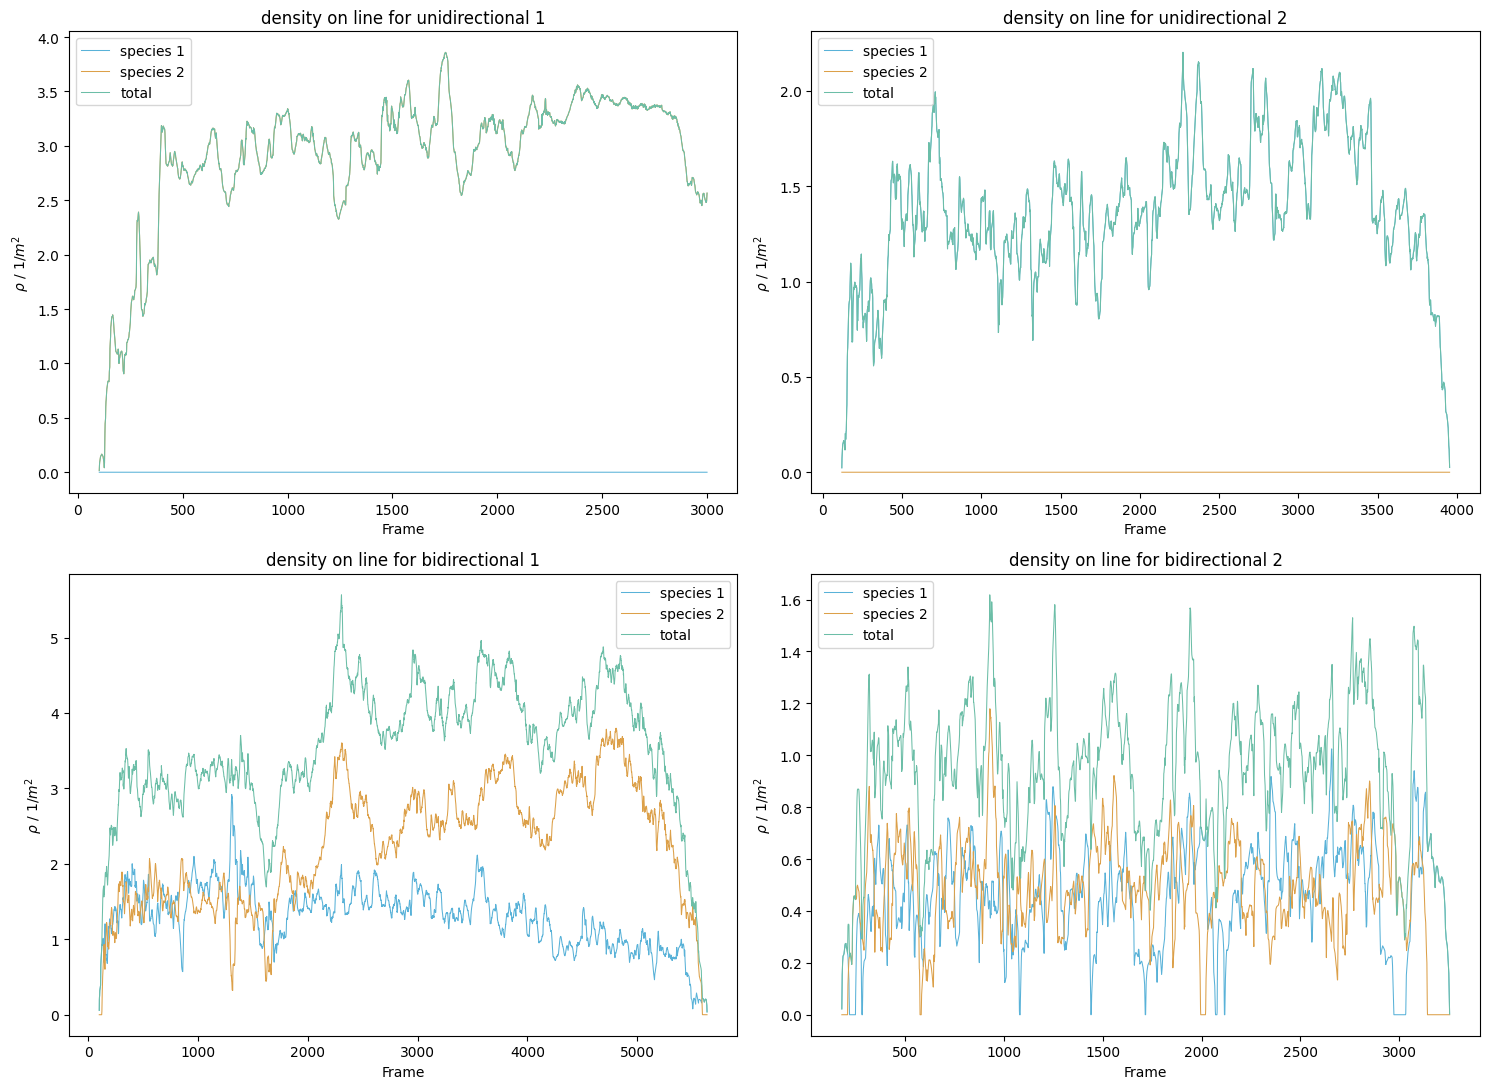

In [16]:
from pedpy.plotting.plotting import plot_density_at_line
import matplotlib.pylab as plt

fig, axs = plt.subplots(2, int(len(densities) / 2), figsize=(15, 11))

for (name, density_on_line), ax in zip(densities.items(), axs.ravel()):
    ax = plot_density_at_line(
        density_at_line=density_on_line,
        axes=ax,
        line_width=0.75,
        title="density on line for " + name,
    )

fig.tight_layout()
plt.show()

## Calculate Flow on Line

The calculation of the flow is derived from the flow equation $J = p v w$.
To compute the flow both the velocity orthogonal to the line and the density inside the Voronoi-Cell need to be considered.
Each species again only regards the pedestrians representing that species. To remedy negative velocities orthogonal to the line of species 2 the movement factor $m$ needs to be multiplied.

$$ j^S = \sum_{i} m * v_i(t) * n_{l0} * \frac{1}{A_i(t)} *  \frac{w_i(t)}{w}  \text{ with } i \epsilon S $$   

to recap all the symbols of the equation: 
$j$ is the flow, $S$ is the species for which the flow is calculated, $i$ is a pedestrian represented by $S$, $m$ is the movement factor calculated while determining the species, $v_i(t)$ is the velocity of pedestrian $i$, $n_{l0}$ is the orthogonal vector of line $l0$, $A_i(t)$ is the amount of space the Voronoi Cell of pedestrian $i$ takes up, $w_i(t)$ is the length of the line intersecting with the Voronoi Cell of pedestrian $i$, $w$ is the total length of the measurement line. 

In [17]:
from pedpy.methods.flow_calculator import compute_line_flow

flows = {}
for name in trajectories:
    flows[name] = compute_line_flow(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        species=species[name],
        individual_speed=individual_speeds[name],
    )

just like the speed and density it is now possible to plot the flow on the line.

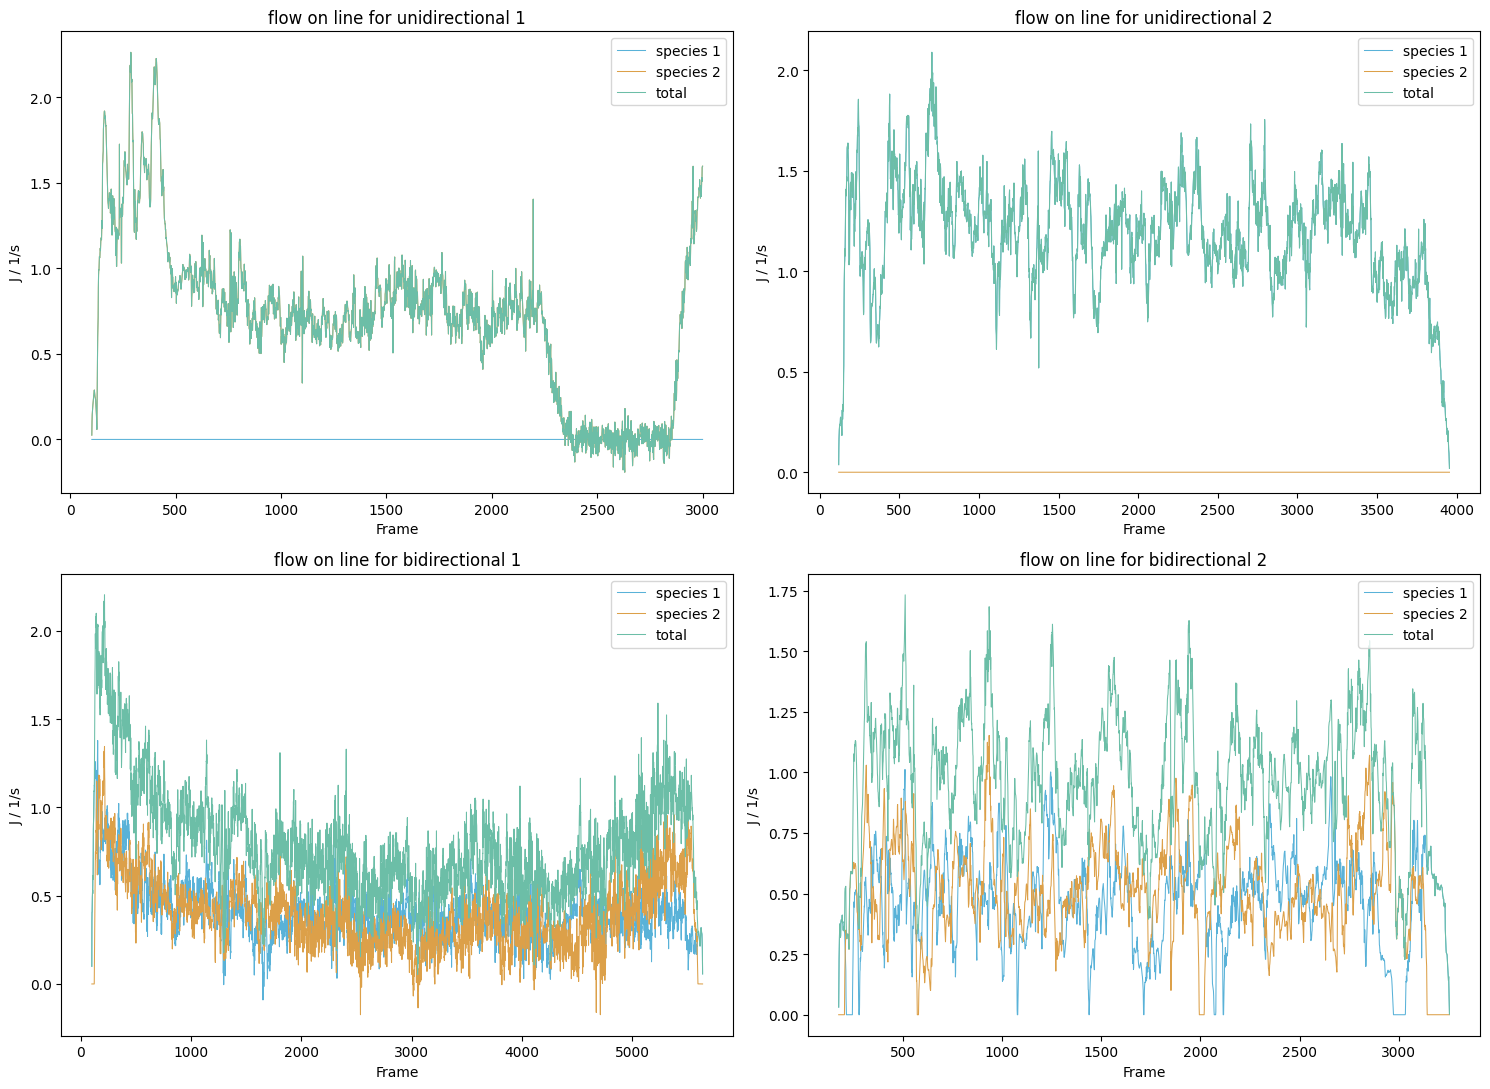

In [18]:
from pedpy.plotting.plotting import plot_flow_at_line
import matplotlib.pylab as plt

fig, axs = plt.subplots(2, int(len(flows) / 2), figsize=(15, 11))

for (name, flow_on_line), ax in zip(flows.items(), axs.ravel()):
    ax = plot_flow_at_line(
        flow_at_line=flow_on_line,
        axes=ax,
        line_width=0.75,
        title="flow on line for " + name,
    )

fig.tight_layout()
plt.show()

## cutting results

When taking a closer look at the trajectory data of the first unidirectional experiment it is visible that not all data from it is usable. This is due to the execution of the experiment. At the end of the experiment all participants are instructed to stand still. Because of this the data can not be used in further analysis. When analysing on your own it is recommended to cut away all data that is unusable.  

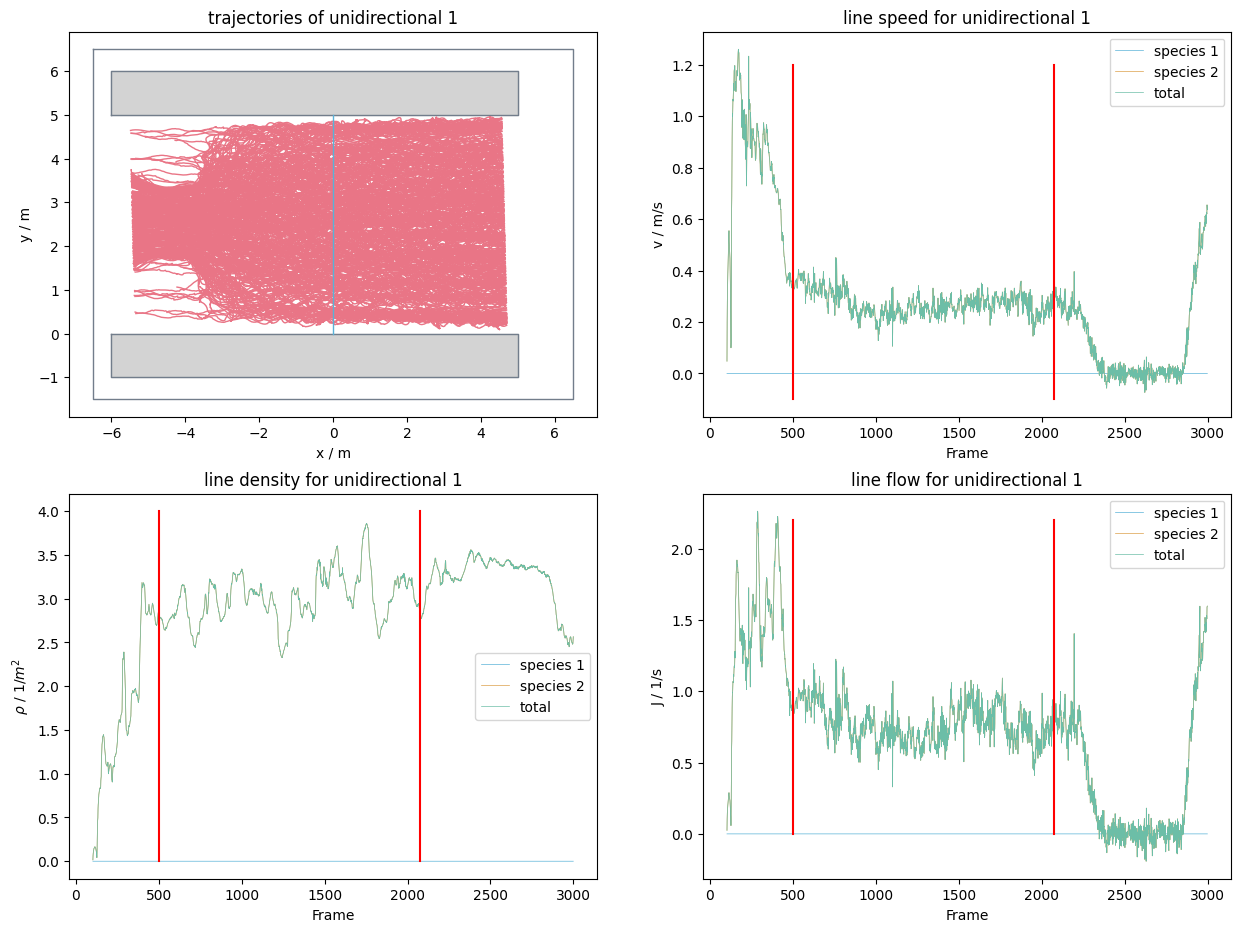

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 11))

name = "unidirectional 1"

interval = [500, 2075]
plot_measurement_setup(
    axes=axs[0, 0],
    traj=trajectories[name],
    walkable_area=walkable_areas[name],
    measurement_lines=[measurement_lines[name]],
)
plot_speed_at_line(
    axes=axs[0, 1], speed_at_line=speeds[name], title=f"line speed for {name}"
)
axs[0, 1].plot([interval[0], interval[0]], [-0.1, 1.2], c="r")
axs[0, 1].plot([interval[1], interval[1]], [-0.1, 1.2], c="r")
plot_density_at_line(
    axes=axs[1, 0],
    density_at_line=densities[name],
    title=f"line density for {name}",
)
axs[1, 0].plot([interval[0], interval[0]], [0, 4], c="r")
axs[1, 0].plot([interval[1], interval[1]], [0, 4], c="r")
plot_flow_at_line(
    axes=axs[1, 1], flow_at_line=flows[name], title=f"line flow for {name}"
)
axs[1, 1].plot([interval[0], interval[0]], [0, 2.2], c="r")
axs[1, 1].plot([interval[1], interval[1]], [0, 2.2], c="r")


axs[0, 0].set_title(f"trajectories of {name}")
plt.show()

In the plots above you can see the trajectories of the first unidirectional experiment as well as the line speed, line density and line flow for said experiment. In between the red lines the measured values will be used for analysis. The additional data outside the red lines is cut for further analysis as the data is unusable.

## creating a fundamental diagram

After completing the calculations it is possible to create a fundamental diagram. Here we will use the precomputed data of 10 unidirectional and 10 bidirectional experiments all using the same experimental setup. First, we define style options that will be used later in the plot.

In [20]:
style_options = {
    "traj_UNI_CORR_500_01": {"color": "red", "marker": "+"},
    "traj_UNI_CORR_500_02": {"color": "green", "marker": "x"},
    "traj_UNI_CORR_500_03": {"color": "blue", "marker": "x"},
    "traj_UNI_CORR_500_04": {
        "color": "white",
        "marker": "s",
        "edgecolors": "pink",
    },
    "traj_UNI_CORR_500_05": {"color": "cyan", "marker": "s"},
    "traj_UNI_CORR_500_06": {"color": "grey", "marker": "^"},
    "traj_UNI_CORR_500_07": {
        "color": "white",
        "marker": "^",
        "edgecolors": "orange",
    },
    "traj_UNI_CORR_500_08": {"color": "black", "marker": "o"},
    "traj_UNI_CORR_500_09": {
        "color": "white",
        "marker": "o",
        "edgecolors": "purple",
    },
    "traj_UNI_CORR_500_10": {"color": "orange", "marker": "+"},
    "bi_corr_400_b_01": {"color": "red", "marker": "+"},
    "bi_corr_400_b_02": {"color": "green", "marker": "x"},
    "bi_corr_400_b_03": {"color": "blue", "marker": "x"},
    "bi_corr_400_b_04": {"color": "white", "marker": "s", "edgecolors": "pink"},
    "bi_corr_400_b_05": {"color": "cyan", "marker": "s"},
    "bi_corr_400_b_06": {"color": "grey", "marker": "^"},
    "bi_corr_400_b_07": {
        "color": "white",
        "marker": "^",
        "edgecolors": "orange",
    },
    "bi_corr_400_b_08": {"color": "black", "marker": "o"},
    "bi_corr_400_b_09": {
        "color": "white",
        "marker": "o",
        "edgecolors": "purple",
    },
    "bi_corr_400_b_10": {"color": "orange", "marker": "+"},
}

The already calculated line speeds and line densities are now loaded.

In [21]:
import pickle
with open('demo-data/uni-directional/unidirectional_data.pkl', 'rb') as file:
    loaded_dictionaries = pickle.load(file)

line_densities_uni = loaded_dictionaries['line_densities_uni']
line_speeds_uni = loaded_dictionaries['line_speeds_uni']

with open('demo-data/bi-directional/bidirectional_data.pkl', 'rb') as file:
    loaded_dictionaries = pickle.load(file)

line_densities_bi = loaded_dictionaries['line_densities_bi']
line_speeds_bi = loaded_dictionaries['line_speeds_bi']

The fundamental diagram can now be created.

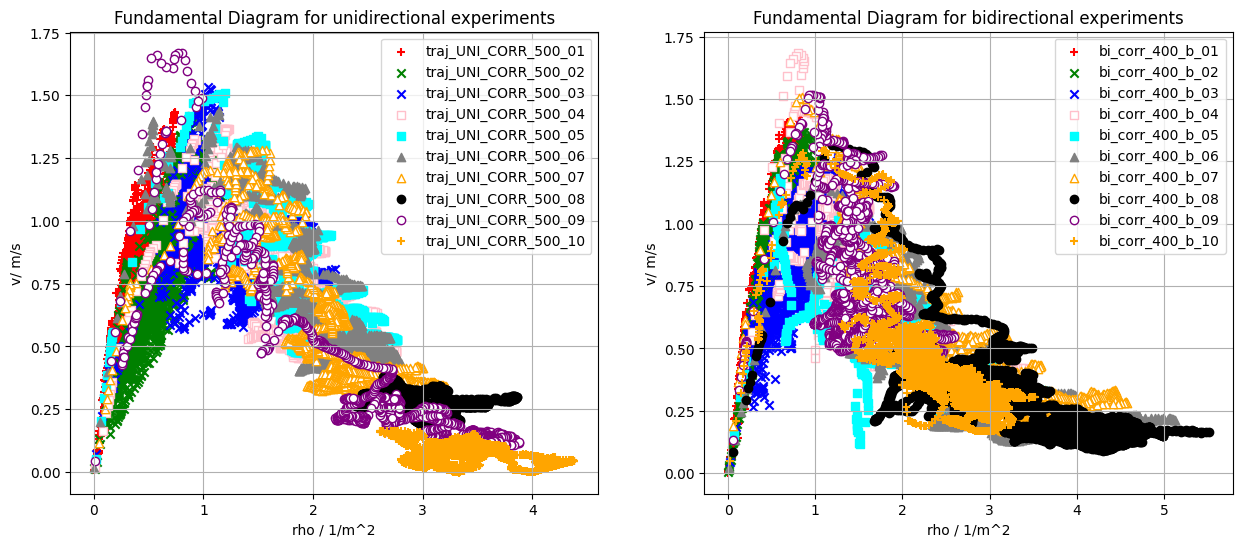

In [22]:
from pedpy.column_identifier import DENSITY_COL, SPEED_COL

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for name in sorted(line_densities_uni.keys()):
    ax1.scatter(
        line_densities_uni[name][DENSITY_COL],
        line_speeds_uni[name][SPEED_COL],
        alpha=1,
        label=name,
        **style_options[name],
    )

for name in sorted(line_densities_bi.keys()):
    ax2.scatter(
        line_densities_bi[name][DENSITY_COL],
        line_speeds_bi[name][SPEED_COL],
        alpha=1,
        label=name,
        **style_options[name],
    )
    
ax1.set_xlabel("rho / 1/m^2")
ax2.set_xlabel("rho / 1/m^2")
ax1.set_ylabel("v/ m/s")
ax2.set_ylabel("v/ m/s")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Fundamental Diagram for unidirectional experiments")
ax2.set_title("Fundamental Diagram for bidirectional experiments")
ax1.legend()
ax2.legend()
plt.show()